In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD


# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [7]:
# # Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [8]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 10
pop_size = 400

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
controller.regularize(0)
_ = learner.learn(50, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 42.82epoch(s)/s, Training loss MSE=1.0080601]


Iteration:  0
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.004494695663452148
obs. reward:  -132.50153
act. reward:  -1.6512452


Network training: 100%|██████████| 10/10 [00:00<00:00, 14.15epoch(s)/s, Training loss MSE=0.37953788]


Iteration:  1
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1321657729148865
obs. reward:  -251.86148
act. reward:  -0.07074903


Network training: 100%|██████████| 10/10 [00:00<00:00, 10.20epoch(s)/s, Training loss MSE=0.13999414]


Iteration:  2
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13238260746002198
obs. reward:  -179.57346
act. reward:  -0.0682722


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.80epoch(s)/s, Training loss MSE=0.081327]  


Iteration:  3
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13284449577331542
obs. reward:  -85.809166
act. reward:  -0.091253705


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.45epoch(s)/s, Training loss MSE=0.05730013]


Iteration:  4
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1319610071182251
obs. reward:  -53.2009
act. reward:  -0.5100389


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.49epoch(s)/s, Training loss MSE=0.046003286]


Iteration:  5
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13201138019561767
obs. reward:  -38.615715
act. reward:  -0.59136623


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.78epoch(s)/s, Training loss MSE=0.21715845]


Iteration:  6
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13190078735351562
obs. reward:  -706.36865
act. reward:  -2.4060595


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.38epoch(s)/s, Training loss MSE=0.24620216]


Iteration:  7
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1320769190788269
obs. reward:  -39.59103
act. reward:  -1.4961373


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.59epoch(s)/s, Training loss MSE=0.18148051]


Iteration:  8
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13248190879821778
obs. reward:  -36.33364
act. reward:  -0.9357105


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.21epoch(s)/s, Training loss MSE=0.16172029]


Iteration:  9
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.132100031375885
obs. reward:  -39.37536
act. reward:  -1.3295276


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.94epoch(s)/s, Training loss MSE=0.15982148]


Iteration:  10
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13299392700195312
obs. reward:  -36.358833
act. reward:  -1.13927


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.71epoch(s)/s, Training loss MSE=0.20964111]


Iteration:  11
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13315125465393066
obs. reward:  -47.418957
act. reward:  -2.1589136


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.52epoch(s)/s, Training loss MSE=0.16194758]


Iteration:  12
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1323881483078003
obs. reward:  -37.243805
act. reward:  -0.6224512


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.33epoch(s)/s, Training loss MSE=0.17149088]


Iteration:  13
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13285773754119873
obs. reward:  -39.60755
act. reward:  -1.5726008


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.19epoch(s)/s, Training loss MSE=0.15086684]


Iteration:  14
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13408786296844483
obs. reward:  -51.33519
act. reward:  -1.5665001


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.04epoch(s)/s, Training loss MSE=0.16172062]


Iteration:  15
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1325034999847412
obs. reward:  -34.65627
act. reward:  -1.3743278


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.90epoch(s)/s, Training loss MSE=0.16605492]


Iteration:  16
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13335055351257324
obs. reward:  -29.403324
act. reward:  -1.0762125


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.80epoch(s)/s, Training loss MSE=0.15802106]


Iteration:  17
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1322558832168579
obs. reward:  -33.235683
act. reward:  -0.9617128


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.71epoch(s)/s, Training loss MSE=0.14308171]


Iteration:  18
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1330364990234375
obs. reward:  -35.067104
act. reward:  -0.93850505


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.62epoch(s)/s, Training loss MSE=0.17496903]


Iteration:  19
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13576411485671996
obs. reward:  -625.62964
act. reward:  -3.4123638


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.60epoch(s)/s, Training loss MSE=0.16260403]


Iteration:  20
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1333806586265564
obs. reward:  -29.975735
act. reward:  -1.1548423


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.68epoch(s)/s, Training loss MSE=0.15867572]


Iteration:  21
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13281633853912353
obs. reward:  -30.259453
act. reward:  -1.0963708


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.65epoch(s)/s, Training loss MSE=0.25647557]


Iteration:  22
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1331962251663208
obs. reward:  -426.5196
act. reward:  -1.9558685


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.56epoch(s)/s, Training loss MSE=0.24886198]


Iteration:  23
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1331125259399414
obs. reward:  -223.81424
act. reward:  -8.520879


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.51epoch(s)/s, Training loss MSE=0.38524914]


Iteration:  24
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13373374938964844
obs. reward:  -550.99207
act. reward:  -5.854997


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.31epoch(s)/s, Training loss MSE=0.4004879]


Iteration:  25
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13378060817718507
obs. reward:  -30.151487
act. reward:  -1.0929213


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.20epoch(s)/s, Training loss MSE=0.3675647]


Iteration:  26
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13427972078323364
obs. reward:  -35.91047
act. reward:  -0.66737545


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.16epoch(s)/s, Training loss MSE=0.36455774]


Iteration:  27
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13390375137329102
obs. reward:  -31.15445
act. reward:  -1.0799117


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.13epoch(s)/s, Training loss MSE=0.35539603]


Iteration:  28
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13281394004821778
obs. reward:  -39.878944
act. reward:  -0.5941297


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.10epoch(s)/s, Training loss MSE=0.27414674]


Iteration:  29
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13332738161087035
obs. reward:  -32.994743
act. reward:  -0.98397523


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.22epoch(s)/s, Training loss MSE=0.32910764]


Iteration:  30
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13389832019805908
obs. reward:  -29.227673
act. reward:  -1.251234


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.11epoch(s)/s, Training loss MSE=0.36769268]


Iteration:  31
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13340336799621583
obs. reward:  -64.0406
act. reward:  -2.391863


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.02s/epoch(s), Training loss MSE=0.2756074]


Iteration:  32
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1345546793937683
obs. reward:  -32.11465
act. reward:  -0.9374857


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.04s/epoch(s), Training loss MSE=0.26179132]


Iteration:  33
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.132911217212677
obs. reward:  -33.839184
act. reward:  -1.4144228


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.07s/epoch(s), Training loss MSE=0.2665803]


Iteration:  34
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1340569305419922
obs. reward:  -30.191257
act. reward:  -1.1580127


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.06s/epoch(s), Training loss MSE=0.26557216]


Iteration:  35
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1341519808769226
obs. reward:  -32.73433
act. reward:  -0.9981364


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.15s/epoch(s), Training loss MSE=0.24376477]


Iteration:  36
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13366199493408204
obs. reward:  -31.850636
act. reward:  -0.95501864


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.18s/epoch(s), Training loss MSE=0.24854329]


Iteration:  37
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1343931221961975
obs. reward:  -39.965984
act. reward:  -1.5594473


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.19s/epoch(s), Training loss MSE=0.25167805]


Iteration:  38
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13481511116027833
obs. reward:  -30.102293
act. reward:  -1.1255014


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.23s/epoch(s), Training loss MSE=0.25161216]


Iteration:  39
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1344720721244812
obs. reward:  -59.363377
act. reward:  -3.1438682


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.15s/epoch(s), Training loss MSE=0.26261944]


Iteration:  40
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1349068832397461
obs. reward:  -52.55978
act. reward:  -2.6462026


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.28s/epoch(s), Training loss MSE=0.25983283]


Iteration:  41
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1328574538230896
obs. reward:  -32.814594
act. reward:  -1.5724515


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.30s/epoch(s), Training loss MSE=0.22610874]


Iteration:  42
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1338421630859375
obs. reward:  -34.74017
act. reward:  -1.3669845


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/epoch(s), Training loss MSE=0.24513197]


Iteration:  43
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13371490955352783
obs. reward:  -28.376907
act. reward:  -1.3056586


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.36s/epoch(s), Training loss MSE=0.22362049]


Iteration:  44
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13422957181930542
obs. reward:  -30.586893
act. reward:  -1.1631893


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.43s/epoch(s), Training loss MSE=0.22658704]


Iteration:  45
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13193602323532105
obs. reward:  -27.50957
act. reward:  -1.3695272


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.43s/epoch(s), Training loss MSE=0.320312] 


Iteration:  46
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.13357418775558472
obs. reward:  -275.0449
act. reward:  -10.496149


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.46s/epoch(s), Training loss MSE=0.2713933]


Iteration:  47
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1380738925933838
obs. reward:  -29.532948
act. reward:  -1.1962717


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.47s/epoch(s), Training loss MSE=0.27144954]


Iteration:  48
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1368146276473999
obs. reward:  -28.669474
act. reward:  -1.2722056


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.54s/epoch(s), Training loss MSE=0.3006962]

Iteration:  49
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.1369020986557007
obs. reward:  -28.354408
act. reward:  -1.3291878


In [11]:
controller.regularize(0)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.13458198070526123
obs. reward:  -141.44856
act. reward:  -0.009575838


In [12]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(2.5022, grad_fn=<MeanBackward0>)
tensor(3.1805, grad_fn=<StdBackward0>)


In [13]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [14]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [15]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

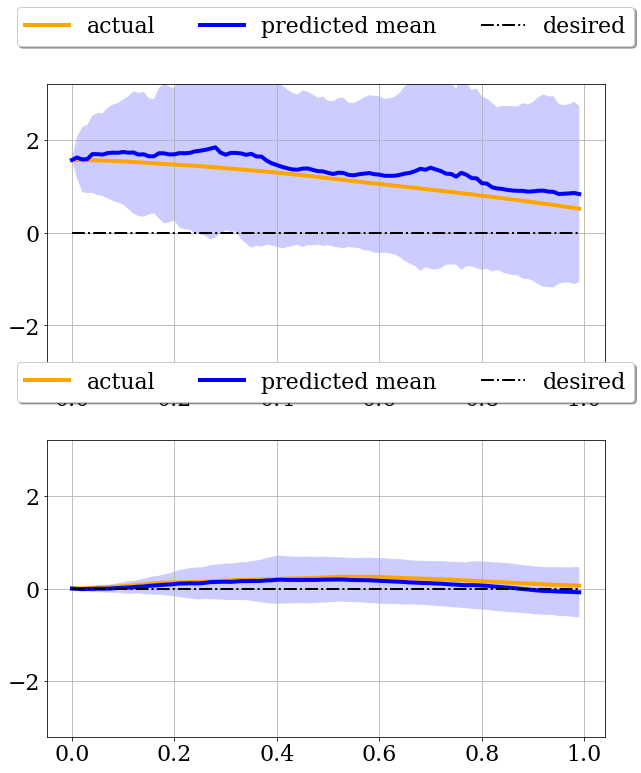

In [16]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')

In [17]:
# import numpy as np
# from stage.tasks.twolink.reaching import TwoLinkReaching
# from stage.utils.nn import use_gpu
# use_gpu()
# savepath = parentdir + '/data/twolink/'
# data_train = np.load(savepath+'data_pd_reg.npy')
# task = TwoLinkReaching(render=True)
# task.visualize_training_data(data_train, 0)